# dpu_resnet50_CIFAR10

In [1]:
from pynq_dpu import DpuOverlay
from PIL import Image as PIL_Image
from IPython.display import clear_output, Image, display, HTML
from torch.utils.data import DataLoader
from torchvision import transforms
overlay = DpuOverlay("dpu.bit")

/usr/local/share/pynq-venv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import datetime
import torch
import torchvision
%matplotlib inline

In [3]:
overlay.load_model("resnet50_dpu.xmodel")

In [18]:
_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

MEANS = [_B_MEAN,_G_MEAN,_R_MEAN]

def resize_shortest_edge(image, size):
    H, W = image.shape[:2]
    if H >= W:
        nW = size
        nH = int(float(H)/W * size)
    else:
        nH = size
        nW = int(float(W)/H * size)
    return cv2.resize(image,(nW,nH))

def mean_image_subtraction(image, means):
    B, G, R = cv2.split(image)
    B = B - means[0]
    G = G - means[1]
    R = R - means[2]
    image = cv2.merge([R, G, B])
    return image

def BGR2RGB(image):
    B, G, R = cv2.split(image)
    image = cv2.merge([R, G, B])
    return image

def central_crop(image, crop_height, crop_width):
    image_height = image.shape[0]
    image_width = image.shape[1]
    offset_height = (image_height - crop_height) // 2
    offset_width = (image_width - crop_width) // 2
    return image[offset_height:offset_height + crop_height, offset_width:
                 offset_width + crop_width, :]

def normalize(image):
    image=image/256.0
    image=image-0.5
    image=image*2
    return image

def preprocess_fn(image): 
    image = cv2.resize(image,(32,32))
#     image = central_crop(image,32,32)
    image = normalize(image)
    image = mean_image_subtraction(image, MEANS)
    return image

In [5]:
def calculate_softmax(data):
    result = np.exp(data)
    return result

def predict_label(softmax):
    with open("words.txt", "r") as f:
        lines = f.readlines()
    th = np.argmax(softmax)
#     print('np.argmax(softmax) :', th, end='    ')
    return lines[th]
#     return th


In [6]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])
softmax = np.empty(outputSize)
# print(dir(inputTensors[0]))
for inputTensor in inputTensors:
    print('inputTensor.name:  ',inputTensor.name)
    print('inputTensor.dims:  ',inputTensor.dims)
    print('inputTensor.dtype: ',inputTensor.dtype)
print(inputTensors)
print('shapeIn:           ',shapeIn)
print('shapeOut:           ',shapeOut)
# print('outputSize:        ',outputSize)
# print('softmax:\n',softmax)

inputTensor.name:   ResNet__input_0_fix
inputTensor.dims:   [1, 32, 32, 3]
inputTensor.dtype:  xint8
[<xir.Tensor named 'ResNet__input_0_fix'>]
shapeIn:            (1, 32, 32, 3)
shapeOut:            (1, 10)


In [7]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]

print('input_data:  ',input_data)
# print('output_data: ',output_data)
# print('image:  ',image)

input_data:   [array([[[[-1.1474482e-38,  9.1834095e-41, -1.1474482e-38],
         [ 9.1834095e-41,  2.6283109e-10,  0.0000000e+00],
         [ 2.6283109e-10,  0.0000000e+00,  1.4012985e-45],
         ...,
         [ 5.3249342e-44,  2.8025969e-45,  5.6051939e-44],
         [ 2.9427268e-44,  0.0000000e+00,  2.6284019e-10],
         [ 0.0000000e+00,  4.1276073e+36,  9.1834095e-41]],

        [[ 1.4012985e-45,  0.0000000e+00,  2.8025969e-45],
         [ 5.3249342e-44,  2.8025969e-45,  6.7262326e-44],
         [ 2.4099364e+38,  9.1834095e-41,  2.6284153e-10],
         ...,
         [ 0.0000000e+00,  2.8025969e-45,  1.4012985e-44],
         [ 1.4012985e-45,  0.0000000e+00,  2.6286262e-10],
         [ 0.0000000e+00,  3.3631163e-44,  8.8281803e-44]],

        [[ 1.7690512e+38,  9.1834095e-41,  1.4012985e-45],
         [ 0.0000000e+00,  2.6285218e-10,  0.0000000e+00],
         [ 2.8025969e-45,  1.9618179e-44,  2.8025969e-45],
         ...,
         [ 0.0000000e+00,  2.3822074e-44,  0.0000000e+

加载数据集

In [12]:
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
testset = torchvision.datasets.CIFAR10(
    root='../CIFAR10', train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=False, num_workers=2)

In [13]:
def test(number):
    best_acc = 0
    test_loss = 0
    correct = 0
    total = 0
    test_acc = 0
    i = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
#         inputs, targets = inputs.to(device), targets.to(device)
        i = i + 1
        if i == number+1:
            break
#       np.reshape 操作为先将多维数组转为一维向量，再按照所设维度进行转换，不建议在图像处理中使用
#       image[0,...] = inputs.reshape(shapeIn[1:])  
#       np.transpose 操作为直接将维度进行置换，可类比二维数组的转置
        image[0,...] = np.transpose(inputs,[0,2,3,1]) 
        job_id = dpu.execute_async(input_data, output_data)
        dpu.wait(job_id)
        temp = [j.reshape(1, outputSize) for j in output_data]
        softmax = calculate_softmax(temp[0][0])
        th = np.argmax(softmax)
        print("Classification: {}".format(predict_label(softmax)),end='      ')
        print('predicted:',th,end='      ')
        print('targets:',targets)

        predicted = torch.tensor(np.argmax(softmax))
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    test_acc = correct / total
    print('Test Accurancy: {}'.format(test_acc))

使用100张数据集图片进行测试

In [15]:
number = 100
starttime = datetime.datetime.now()
test(number)
endtime = datetime.datetime.now()
print((endtime-starttime)/number)

Classification: cat
      predicted: 3      targets: tensor([3])
Classification: ship
      predicted: 8      targets: tensor([8])
Classification: ship
      predicted: 8      targets: tensor([8])
Classification: airplane
      predicted: 0      targets: tensor([0])
Classification: frog
      predicted: 6      targets: tensor([6])
Classification: frog
      predicted: 6      targets: tensor([6])
Classification: automobile
      predicted: 1      targets: tensor([1])
Classification: frog
      predicted: 6      targets: tensor([6])
Classification: cat
      predicted: 3      targets: tensor([3])
Classification: automobile
      predicted: 1      targets: tensor([1])
Classification: airplane
      predicted: 0      targets: tensor([0])
Classification: truck      predicted: 9      targets: tensor([9])
Classification: dog
      predicted: 5      targets: tensor([5])
Classification: horse
      predicted: 7      targets: tensor([7])
Classification: truck      predicted: 9      targets: tens

定义获取摄像头输入函数

In [21]:
def runCap(imageCap,display=False):
    preprocessed = preprocess_fn(img)
    image[0,...] = preprocessed
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    if display:
        display_image = img
        _, ax = plt.subplots(1)
        _ = ax.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
    print("Classification: {}".format(predict_label(softmax)))

对摄像头输入进行识别

True
True
Classification: bird

0:00:00.232464


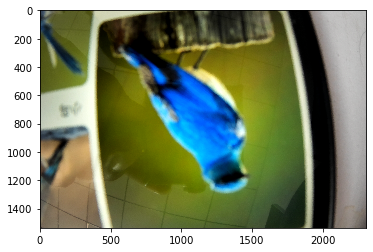

In [35]:
# retval = cv2.VideoCapture.open(0)
cap = cv2.VideoCapture(0)
print(cap.isOpened())
if cap.isOpened() == True:
        ret,img = cap.read()
        print(ret)
        starttime = datetime.datetime.now()
        runCap(img,display=True)
        endtime = datetime.datetime.now()
        print(endtime - starttime)

In [20]:
del overlay
del dpu

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----